In [109]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [110]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [111]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.10750,1.100000,1.30,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.81800,7.300000,1.40,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.88520,30.000000,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.76250,111.300000,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.76570,1.900000,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30T03:46:53.207Z,63.278200,-151.25170,7.400000,1.00,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
28331,2022-01-30T03:44:08.272Z,67.671500,-160.82990,6.200000,2.90,ml,NaN,NaN,NaN,0.5700,...,2022-02-25T03:00:49.040Z,"79 km NNW of Kiana, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
28332,2022-01-30T03:37:46.570Z,19.221167,-155.38916,31.940001,1.83,md,43.0,152.00,NaN,0.1300,...,2022-01-30T03:40:57.760Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.59,1.16,0.620,5.0,automatic,hv,hv
28333,2022-01-30T03:32:41.102Z,2.757300,128.23460,53.450000,4.50,mb,NaN,194.00,2.154,1.0300,...,2022-02-05T01:40:12.040Z,"Halmahera, Indonesia",earthquake,12.30,10.40,0.272,5.0,reviewed,us,us


In [112]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.10750,1.100000,1.30,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.81800,7.300000,1.40,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.88520,30.000000,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.76250,111.300000,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.76570,1.900000,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30 03:46:53.207000+00:00,63.278200,-151.25170,7.400000,1.00,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
28331,2022-01-30 03:44:08.272000+00:00,67.671500,-160.82990,6.200000,2.90,ml,NaN,NaN,NaN,0.5700,...,2022-02-25T03:00:49.040Z,"79 km NNW of Kiana, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
28332,2022-01-30 03:37:46.570000+00:00,19.221167,-155.38916,31.940001,1.83,md,43.0,152.00,NaN,0.1300,...,2022-01-30T03:40:57.760Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.59,1.16,0.620,5.0,automatic,hv,hv
28333,2022-01-30 03:32:41.102000+00:00,2.757300,128.23460,53.450000,4.50,mb,NaN,194.00,2.154,1.0300,...,2022-02-05T01:40:12.040Z,"Halmahera, Indonesia",earthquake,12.30,10.40,0.272,5.0,reviewed,us,us


In [113]:
#adding column of converted time to datetime
model_df['Unix_Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix_Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [114]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix_Time


In [115]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix_Time
0,37.384000,-117.10750,1.100000,1.30,1.641433e+09
1,38.181000,-117.81800,7.300000,1.40,1.641433e+09
2,61.340700,-149.88520,30.000000,1.50,1.641432e+09
3,62.870300,-150.76250,111.300000,2.10,1.641432e+09
4,64.014500,-148.76570,1.900000,1.50,1.641431e+09
...,...,...,...,...,...
28330,63.278200,-151.25170,7.400000,1.00,1.643514e+09
28331,67.671500,-160.82990,6.200000,2.90,1.643514e+09
28332,19.221167,-155.38916,31.940001,1.83,1.643514e+09
28333,2.757300,128.23460,53.450000,4.50,1.643514e+09


In [116]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix_Time    0
dtype: int64

In [117]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [118]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix_Time    0
dtype: int64

In [119]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['Unix_Time'], axis = 1)

y = cleaned_df_dropped[['Unix_Time']]

In [120]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((28329, 4), (28329, 1))

In [121]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [123]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 5838034019476.769, 	R2 score: -0.39922418228120304, 	Model score: -0.39922418228120304
n_estimators=3:
	Mean Squared Error: 5181922691937.098, 	R2 score: -0.24197144399647308, 	Model score: -0.24197144399647308
n_estimators=4:
	Mean Squared Error: 4918546917311.899, 	R2 score: -0.17884715392670558, 	Model score: -0.17884715392670558
n_estimators=5:
	Mean Squared Error: 4765469302565.403, 	R2 score: -0.14215845022874052, 	Model score: -0.14215845022874052
n_estimators=6:
	Mean Squared Error: 4668347462880.543, 	R2 score: -0.11888088345517889, 	Model score: -0.11888088345517889
n_estimators=7:
	Mean Squared Error: 4559484010907.799, 	R2 score: -0.09278915907353102, 	Model score: -0.09278915907353102
n_estimators=8:
	Mean Squared Error: 4497540855588.133, 	R2 score: -0.07794300357650563, 	Model score: -0.07794300357650563
n_estimators=9:
	Mean Squared Error: 4439936399571.631, 	R2 score: -0.0641367209141328, 	Model score: -0.0641367209141328
n_estimato

In [124]:
#create and run model: Now with 200 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 50:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 5838034019476.769, 	R2: -0.39922418228120304, 	Model score: -0.39922418228120304
n_estimators=3:
	Mean Squared Error: 5181922691937.098, 	R2: -0.24197144399647308, 	Model score: -0.24197144399647308
n_estimators=4:
	Mean Squared Error: 4918546917311.899, 	R2: -0.17884715392670558, 	Model score: -0.17884715392670558
n_estimators=5:
	Mean Squared Error: 4765469302565.403, 	R2: -0.14215845022874052, 	Model score: -0.14215845022874052
n_estimators=6:
	Mean Squared Error: 4668347462880.543, 	R2: -0.11888088345517889, 	Model score: -0.11888088345517889
n_estimators=7:
	Mean Squared Error: 4559484010907.799, 	R2: -0.09278915907353102, 	Model score: -0.09278915907353102
n_estimators=8:
	Mean Squared Error: 4497540855588.133, 	R2: -0.07794300357650563, 	Model score: -0.07794300357650563
n_estimators=9:
	Mean Squared Error: 4439936399571.631, 	R2: -0.0641367209141328, 	Model score: -0.0641367209141328
n_estimators=10:
	Mean Squared Error: 4396102116368.24, 	R

Cross-Validation

In [125]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 2833  2834  2835 ... 28326 28327 28328] | test: [   0    1    2 ... 2830 2831 2832]
Train: [    0     1     2 ... 28326 28327 28328] | test: [2833 2834 2835 ... 5663 5664 5665]
Train: [    0     1     2 ... 28326 28327 28328] | test: [5666 5667 5668 ... 8496 8497 8498]
Train: [    0     1     2 ... 28326 28327 28328] | test: [ 8499  8500  8501 ... 11329 11330 11331]
Train: [    0     1     2 ... 28326 28327 28328] | test: [11332 11333 11334 ... 14162 14163 14164]
Train: [    0     1     2 ... 28326 28327 28328] | test: [14165 14166 14167 ... 16995 16996 16997]
Train: [    0     1     2 ... 28326 28327 28328] | test: [16998 16999 17000 ... 19828 19829 19830]
Train: [    0     1     2 ... 28326 28327 28328] | test: [19831 19832 19833 ... 22661 22662 22663]
Train: [    0     1     2 ... 28326 28327 28328] | test: [22664 22665 22666 ... 25494 25495 25496]
Train: [    0     1     2 ... 25494 25495 25496] | test: [25497 25498 25499 ... 28326 28327 28328]


In [126]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[ -40.53862058 -169.208578   -227.68514457   -0.57160056  -19.38085432
  -35.20020715   -1.65103406 -167.34990939 -125.31786098  -94.82205549]


In [127]:
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [128]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

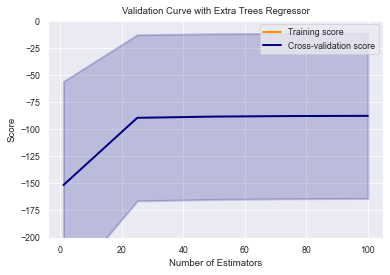

In [129]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(-200, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [130]:
testpred = best_model.predict(X_test)
actual_time = y_test
testpredict = []
for item in testpred:
    testpredict.append(item)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 2046647.006337


In [131]:
print(actual_time)

          Unix_Time
8870   1.641518e+09
3587   1.640179e+09
6356   1.639456e+09
11229  1.643183e+09
2900   1.640377e+09
...             ...
5282   1.639748e+09
13083  1.642671e+09
21510  1.645033e+09
25047  1.644172e+09
19988  1.645448e+09

[9349 rows x 1 columns]


In [132]:
time_pred = actual_time
time_pred['Predicted'] = testpredict


In [133]:
time_pred_all = time_pred.rename(columns={'Unix_Time': 'Actual'})

In [134]:
time_pred_all

,Actual,Predicted
8870,1.641518e+09,1.644259e+09
3587,1.640179e+09,1.642540e+09
6356,1.639456e+09,1.643002e+09
11229,1.643183e+09,1.643178e+09
2900,1.640377e+09,1.640623e+09
...,...,...
5282,1.639748e+09,1.642480e+09
13083,1.642671e+09,1.642120e+09
21510,1.645033e+09,1.644379e+09
25047,1.644172e+09,1.642896e+09


In [135]:
time_pred_all = time_pred_all.merge(cleaned_df, how='inner', left_index=True, right_index=True)
time_pred_all = time_pred_all.rename(columns={'Unix_Time_x': 'Actual', 'Unix_Time_y': 'Unix_Time'})
time_pred_all

,Actual,Predicted,latitude,longitude,depth,mag,Unix_Time
8870,1.641518e+09,1.644259e+09,38.787000,-122.734167,1.72,0.12,1.641518e+09
3587,1.640179e+09,1.642540e+09,38.230500,-112.381000,8.81,1.95,1.640179e+09
6356,1.639456e+09,1.643002e+09,-28.686100,-71.555500,17.79,5.50,1.639456e+09
11229,1.643183e+09,1.643178e+09,37.627667,-118.893500,2.71,0.11,1.643183e+09
2900,1.640377e+09,1.640623e+09,62.446400,-148.337100,33.50,1.70,1.640377e+09
...,...,...,...,...,...,...,...
5282,1.639748e+09,1.642480e+09,38.556100,-119.467700,6.70,0.90,1.639748e+09
13083,1.642671e+09,1.642120e+09,38.167000,-117.875700,13.20,0.80,1.642671e+09
21510,1.645033e+09,1.644379e+09,46.192000,-122.202333,4.62,-0.20,1.645033e+09
25047,1.644172e+09,1.642896e+09,7.367500,-80.497000,10.00,4.60,1.644172e+09


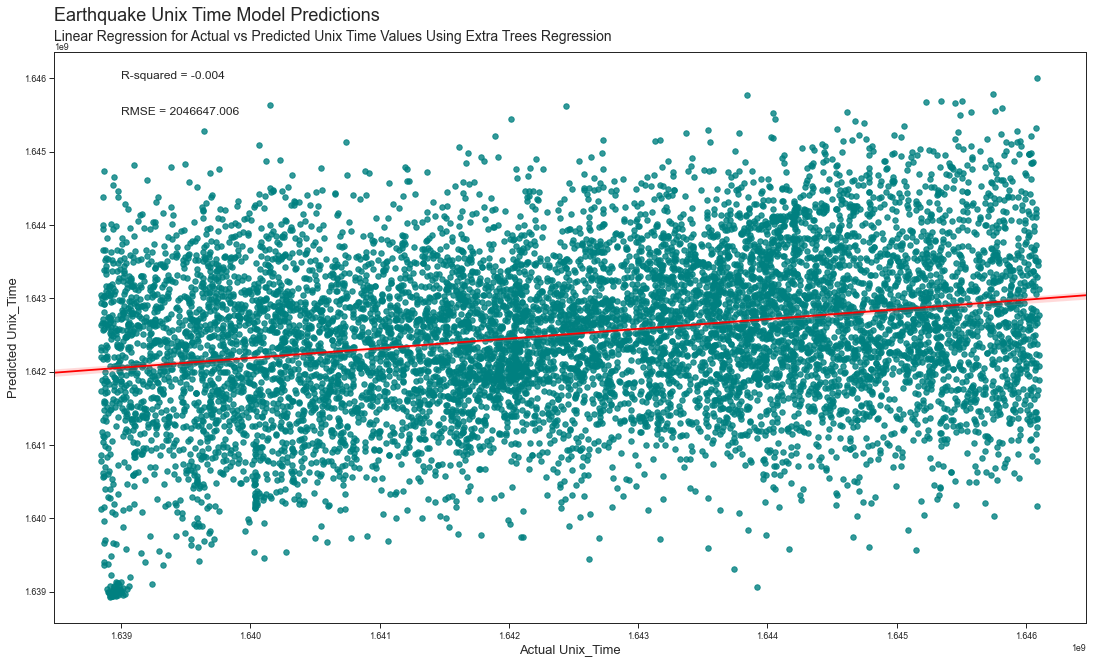

In [136]:
x = np.array(time_pred_all['Unix_Time'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Unix_Time', fontsize=13)
plt.xlabel('Actual Unix_Time',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Unix Time Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Unix Time Values Using Extra Trees Regression', x=0, y=1.01,loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(time_pred_all['Unix_Time'], testpredict)), (1.639*(10**9), 1.646*(10**9)),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (1.639*(10**9), 1.6455*(10**9)), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS

In [137]:

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-04T01:18:41.980Z,34.313500,-116.448167,9.37,1.11,ml,13.0,76.0,0.058580,0.11,...,2022-03-04T01:22:20.540Z,"22km N of Yucca Valley, CA",earthquake,0.28,0.48,0.180000,17.0,automatic,ci,ci
1,2022-03-04T01:13:59.670Z,35.668333,-117.470167,6.92,1.45,ml,18.0,112.0,0.081910,0.17,...,2022-03-04T01:17:39.907Z,"12km SSW of Searles Valley, CA",earthquake,0.41,0.83,0.167000,16.0,automatic,ci,ci
2,2022-03-04T01:01:47.847Z,60.846100,-150.595900,41.30,1.60,ml,NaN,NaN,NaN,0.35,...,2022-03-04T01:12:17.988Z,"9 km SSE of Point Possession, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak
3,2022-03-04T00:35:47.360Z,38.827168,-122.855499,2.47,1.19,md,25.0,72.0,0.001137,0.02,...,2022-03-04T00:44:11.126Z,"10km WNW of The Geysers, CA",earthquake,0.21,0.42,0.030000,5.0,automatic,nc,nc
4,2022-03-04T00:35:41.460Z,17.953333,-67.084667,11.73,2.54,md,9.0,253.0,NaN,0.09,...,2022-03-04T01:16:13.160Z,"4 km WSW of La Parguera, Puerto Rico",earthquake,0.59,0.24,0.027768,3.0,reviewed,pr,pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2022-03-03T01:37:39.887Z,61.069100,-139.971400,13.20,1.30,ml,NaN,NaN,NaN,0.51,...,2022-03-03T01:59:41.544Z,"138 km WNW of Haines Junction, Canada",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak
288,2022-03-03T01:31:00.393Z,-42.629600,-83.160700,10.00,5.00,mww,NaN,92.0,8.498000,0.78,...,2022-03-03T17:24:11.040Z,West Chile Rise,earthquake,7.70,1.90,0.059000,28.0,reviewed,us,us
289,2022-03-03T01:30:27.320Z,37.516167,-118.772500,5.50,1.25,md,19.0,64.0,0.086370,0.03,...,2022-03-03T04:55:09.549Z,"10km WSW of Toms Place, CA",earthquake,0.28,1.05,0.136000,15.0,reviewed,nc,nc
290,2022-03-03T01:28:54.740Z,39.424833,-110.323167,-1.16,0.98,md,5.0,191.0,0.001667,0.01,...,2022-03-03T17:20:42.610Z,"15 km SSE of Sunnyside, Utah",earthquake,1.84,0.22,0.228000,5.0,reviewed,uu,uu


In [138]:

test_df['Unix_Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix_Time
0,34.313500,-116.448167,9.37,1.11,1.646357e+09
1,35.668333,-117.470167,6.92,1.45,1.646356e+09
2,60.846100,-150.595900,41.30,1.60,1.646356e+09
3,38.827168,-122.855499,2.47,1.19,1.646354e+09
4,17.953333,-67.084667,11.73,2.54,1.646354e+09
...,...,...,...,...,...
287,61.069100,-139.971400,13.20,1.30,1.646271e+09
288,-42.629600,-83.160700,10.00,5.00,1.646271e+09
289,37.516167,-118.772500,5.50,1.25,1.646271e+09
290,39.424833,-110.323167,-1.16,0.98,1.646271e+09


In [139]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix_Time    0
dtype: int64

In [140]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['Unix_Time'], axis = 1)

y_test_data = cleaned_test_df[['Unix_Time']]


In [141]:
pred_data_y = best_model.predict(X_test_data)

test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix_Time,Predicted
0,34.313500,-116.448167,9.37,1.11,1.646357e+09,1.640101e+09
1,35.668333,-117.470167,6.92,1.45,1.646356e+09,1.642235e+09
2,60.846100,-150.595900,41.30,1.60,1.646356e+09,1.641780e+09
3,38.827168,-122.855499,2.47,1.19,1.646354e+09,1.642346e+09
4,17.953333,-67.084667,11.73,2.54,1.646354e+09,1.643532e+09
...,...,...,...,...,...,...
287,61.069100,-139.971400,13.20,1.30,1.646271e+09,1.642800e+09
288,-42.629600,-83.160700,10.00,5.00,1.646271e+09,1.641918e+09
289,37.516167,-118.772500,5.50,1.25,1.646271e+09,1.642392e+09
290,39.424833,-110.323167,-1.16,0.98,1.646271e+09,1.641927e+09


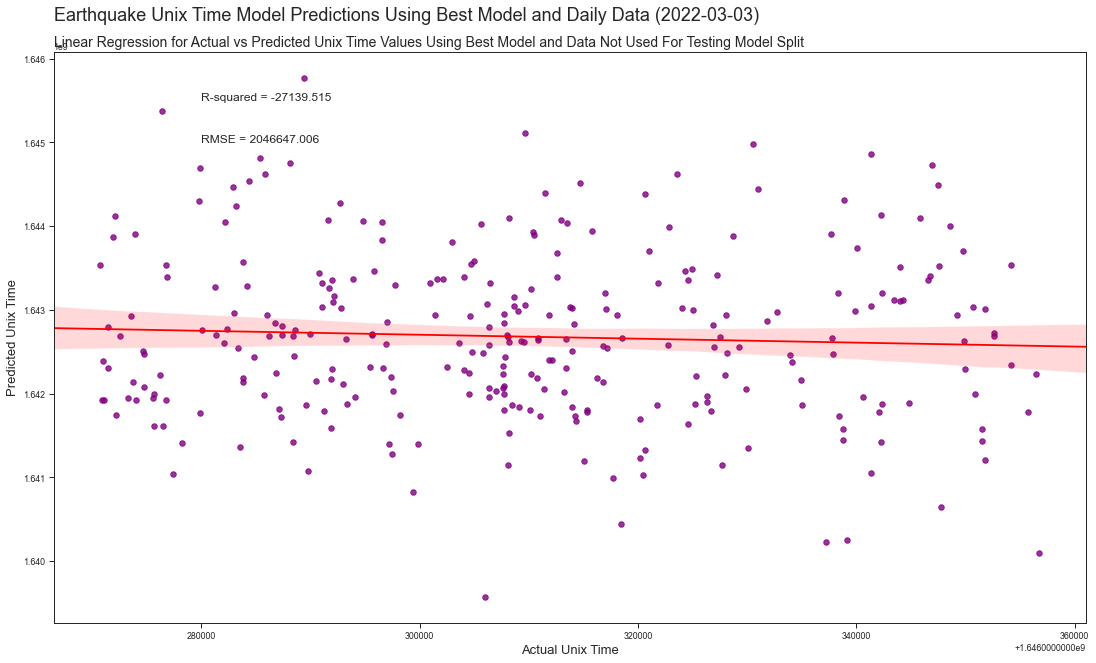

In [153]:
x = np.array(test_pred_data['Unix_Time'])
y = np.array(test_pred_data['Predicted'])

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Unix Time', fontsize=13)
plt.xlabel('Actual Unix Time',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Unix Time Model Predictions Using Best Model and Daily Data (2022-03-03)', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Unix Time Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (1.64628*(10**9), 1.6455*(10**9)),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (1.64628*(10**9), 1.645*(10**9)), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()